# Import Statements

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import math
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import PIL
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings('ignore')
import tensorflow_addons as tfa
from tensorflow.keras.metrics import top_k_categorical_accuracy, categorical_accuracy

In [2]:
root = "D:\IIIT-D\Summer Semester\CAPSTONE PROJECT\Complete Dataset"

In [3]:
train_dir = root+'/Hair Removed Images/train'
val_dir = root+'/Hair Removed Images/val'
test_dir = root+'/Hair Removed Images/test'

# Build A Model

## Preprocessing

In [4]:
train_datagen = ImageDataGenerator(rescale= 1./255,
                                   featurewise_center=False,  # set input mean to 0 over the dataset
                                   samplewise_center=False,  # set each sample mean to 0
                                   featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                   samplewise_std_normalization=False,  # divide each input by its std
                                   zca_whitening=False,  # apply ZCA whitening
                                   rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
                                   zoom_range = 0.1, # Randomly zoom image 
                                   width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                   height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                   horizontal_flip=True,  # randomly flip images
                                   vertical_flip=True,  # randomly flip images
                                   shear_range = 10)

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_data = train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32,class_mode='categorical')

Found 40253 images belonging to 7 classes.


In [7]:
val_data = test_datagen.flow_from_directory(val_dir,target_size=(224,224),batch_size=32,class_mode='categorical')

Found 1000 images belonging to 7 classes.


In [8]:
test_data = test_datagen.flow_from_directory(test_dir,target_size=(224,224),batch_size=32,class_mode='categorical')

Found 1007 images belonging to 7 classes.


# Building The CNN

In [9]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(7,activation='softmax')(x) #final layer with softmax activation

In [10]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [11]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [12]:
def top_1_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=1)

In [13]:
def top_2_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [14]:
def top_3_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [15]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',
                                                                        top_1_acc,
                                                                        top_2_acc,
                                                                        top_3_acc,
                                                                        tf.metrics.AUC(curve='ROC'),
                                                                        tfa.metrics.MatthewsCorrelationCoefficient(num_classes=7)])

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [17]:
lrReduction=ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=2, 
                              verbose=1, 
                              mode='min', 
                              min_lr=0.00001)

In [18]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

In [19]:
step_size_train=train_data.n//train_data.batch_size
history = model.fit_generator(generator=train_data,
                   steps_per_epoch=step_size_train,
                   validation_data=val_data,
                    epochs=30, 
                    verbose = 1,
                             callbacks=[lrReduction, early_stopping])

Epoch 1/30
1257/1257 [==============================] - 1359s 1s/step - loss: 0.8086 - accuracy: 0.7096 - top_1_acc: 0.7096 - top_2_acc: 0.8656 - top_3_acc: 0.9410 - auc: 0.9451 - MatthewsCorrelationCoefficient: 0.6615 - val_loss: 0.7662 - val_accuracy: 0.7540 - val_top_1_acc: 0.7540 - val_top_2_acc: 0.8800 - val_top_3_acc: 0.9540 - val_auc: 0.9556 - val_MatthewsCorrelationCoefficient: 0.4789
Epoch 2/30
1257/1257 [==============================] - 840s 668ms/step - loss: 0.5422 - accuracy: 0.8056 - top_1_acc: 0.8056 - top_2_acc: 0.9302 - top_3_acc: 0.9773 - auc: 0.9743 - MatthewsCorrelationCoefficient: 0.7733 - val_loss: 0.7025 - val_accuracy: 0.7730 - val_top_1_acc: 0.7730 - val_top_2_acc: 0.8980 - val_top_3_acc: 0.9630 - val_auc: 0.9599 - val_MatthewsCorrelationCoefficient: 0.5396
Epoch 3/30
1257/1257 [==============================] - 511s 406ms/step - loss: 0.4454 - accuracy: 0.8398 - top_1_acc: 0.8398 - top_2_acc: 0.9484 - top_3_acc: 0.9851 - auc: 0.9821 - MatthewsCorrelationCoeff

In [21]:
loss,accuracy,top_1,top_2,top_3,auc,mcc = model.evaluate(train_data)

1258/1258 [==============================] - 974s 774ms/step - loss: 0.0912 - accuracy: 0.9667 - top_1_acc: 0.9667 - top_2_acc: 0.9953 - top_3_acc: 0.9995 - auc: 0.9990 - MatthewsCorrelationCoefficient: 0.9611


In [20]:
loss,accuracy,top_1,top_2,top_3,auc,mcc = model.evaluate(test_data)

32/32 [==============================] - 7s 221ms/step - loss: 0.7472 - accuracy: 0.8232 - top_1_acc: 0.8232 - top_2_acc: 0.9394 - top_3_acc: 0.9742 - auc: 0.9630 - MatthewsCorrelationCoefficient: 0.6474


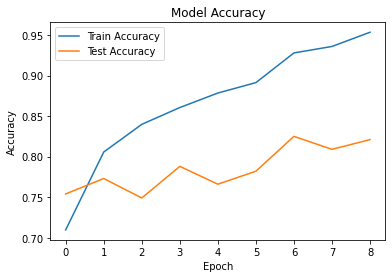

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')
plt.show()

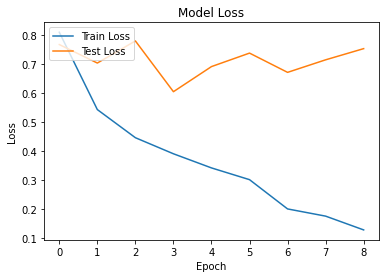

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Test Loss'], loc='upper left')
plt.show()

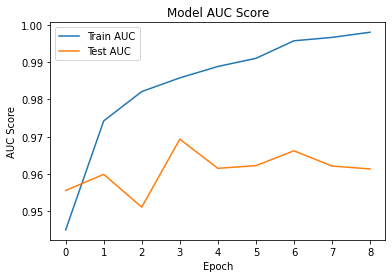

In [24]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC Score')
plt.ylabel('AUC Score')
plt.xlabel('Epoch')
plt.legend(['Train AUC', 'Test AUC'], loc='upper left')
plt.show()